# Tutorial 1: Integration of mouse embryonic brain data

In this tutorial, we demonstrate the integration of spatial multi-omics data using the SpaMI model for more fine-grained spatial domain delineation. We take the mouse embryonic brain dataset obtained by the MISAR-seq technique as an example. The technology simultaneously sequences chromatin accessibility and gene expression to obtain spatial multi-omics data. The dataset can be found https://figshare.com/articles/dataset/SpaMI_dataset/28059641

The SpaMI model is based on the pytorch framework and can be run on GPU or CPU. This tutorial is implemented on an NVIDIA GeForce RTX 3090.

## Loading package

In [1]:
import h5py
import torch
import sklearn
import episcanpy
import numpy as np
import pandas as pd
import scanpy as sc
from anndata import AnnData
from utils import fix_seed

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
random_seed = 2024
fix_seed(2024)

## Loading data

Since the files in this dataset are in .h5 format, we use the h5py package to load them.

In [3]:
rna_file = '/home/gaocongqiang/SpaMI/data/MISAR/MISAR_seq_mouse_E15_brain_mRNA_data.h5'
atac_file = '/home/gaocongqiang/SpaMI/data/MISAR/MISAR_seq_mouse_E15_brain_ATAC_data.h5'

with h5py.File(rna_file, 'r') as file:
        gene_counts = file['X'][:]
        cell_barcodes = file['cell'][:]
        gene_names = file['gene'][:]
        spatial_locations = file['pos'][:]

adata_omics1 = AnnData(X=gene_counts,
                         obs=pd.DataFrame(index=cell_barcodes),
                         var=pd.DataFrame(index=gene_names))
adata_omics1.obsm['spatial'] = spatial_locations


with h5py.File(atac_file, 'r') as file:
        peak_counts = file['X'][:]
        cell_barcodes = file['cell'][:]
        peak_names = file['peak'][:]

adata_omics2 = AnnData(X=peak_counts,
                         obs=pd.DataFrame(index=cell_barcodes),
                         var=pd.DataFrame(index=peak_names))
adata_omics2.obsm['spatial'] = spatial_locations

## Preprocessing data

We use standard preprocessing steps for the different omics data. Specifically, for the transcriptomics data, we initially filtered out genes expressed in fewer than 10 spots from the gene expression profiles. Subsequent steps included log transformation and normalization of the data, identification of 1800 highly variable genes, and dimensionality reduction via PCA to 50 dimensions to refine our analysis further. For the chromatin accessibility data, we binarized the initial count matrix, excluded peaks activated in less than 0.5% of spots to enhance data quality, and employed Latent Semantic Indexing (LSI) to reduce the data dimensionality to 50 dimensions.

In [4]:
sc.pp.filter_genes(adata_omics1, min_cells=10)
sc.pp.normalize_total(adata_omics1, target_sum=1e4)
sc.pp.log1p(adata_omics1)
sc.pp.highly_variable_genes(adata_omics1, n_top_genes=1800)
adata_omics1_copy = adata_omics1[:, adata_omics1.var['highly_variable']]

from scipy.sparse.csc import csc_matrix
from scipy.sparse.csr import csr_matrix

if isinstance(adata_omics1_copy.X, csc_matrix) or isinstance(adata_omics1_copy.X, csr_matrix):
    feat_omics1 = adata_omics1_copy.X.toarray()[:, ]
else:
    feat_omics1 = adata_omics1_copy.X[:, ]
pca = sklearn.decomposition.PCA(n_components=50)
feat_omics1 = pca.fit_transform(feat_omics1)

In [5]:
from preprocess import tfidf

adata_omics2_copy = adata_omics2.copy()
episcanpy.pp.binarize(adata_omics2_copy)
episcanpy.pp.filter_features(adata_omics2_copy, min_cells=np.ceil(0.005 * adata_omics2.shape[0]))
count_mat = adata_omics2_copy.X.copy()
X = tfidf(count_mat)
X_norm = sklearn.preprocessing.Normalizer(norm="l1").fit_transform(X)
X_norm = np.log1p(X_norm * 1e4)
X_lsi = sklearn.utils.extmath.randomized_svd(X_norm, 51)[0]
X_lsi -= X_lsi.mean(axis=1, keepdims=True)
X_lsi /= X_lsi.std(axis=1, ddof=1, keepdims=True)
X_lsi = X_lsi[:, 1:]
if isinstance(X_lsi, csc_matrix) or isinstance(X_lsi, csr_matrix):
    feat_omics2 = X_lsi.toarray()[:, ]
else:
    feat_omics2 = X_lsi[:, ]

Next, we need to create the spatial neighbor graph and obtain the labels required for subsequent contrastive learning. When creating the spatial graph, the number of neighbors per spot is set to 3 for this dataset. Finally, we get the preprocessed data required for model training.

In [6]:
from preprocess import construct_adj, add_contrastive_label

adj_omics1, graph_neigh_omics1 = construct_adj(adata_omics1, n_neighbors=3)
label_CSL_omics1 = add_contrastive_label(adata_omics1)

omics1_data = {
        'feat': feat_omics1,
        'adj': adj_omics1,
        'graph_neigh': graph_neigh_omics1,
        'label_CSL': label_CSL_omics1,
    }

In [7]:
adj_omics2, graph_neigh_omics2 = construct_adj(adata_omics2, n_neighbors=3)
label_CSL_omics2 = add_contrastive_label(adata_omics2)
omics2_data = {
        'feat': feat_omics2,
        'adj': adj_omics2,
        'graph_neigh': graph_neigh_omics2,
        'label_CSL': label_CSL_omics2,
    }

## Training the model

The SpaMI model further refines the latent representation of each modality's spot by associating it with its local context through a contrastive learning strategy. Finally, the latent representations of each modality are adaptively integrated through an attention aggregation mechanism to obtain a joint representation.

After the model training is completed, the model can output the latent joint embedding of spots. The joint representation can be used for a variety of downstream analyses such as clustering, visualization, and identification of differentially expressed features.

In [8]:
from main import train

train(omics1_data, omics2_data, 'MISAR', out_dim=20)

100%|██████████| 800/800 [00:21<00:00, 38.00it/s]


Model training completed!


## Clustering and Visualization

In [9]:
result = np.load('../result/MISAR/combine_emb.npy')

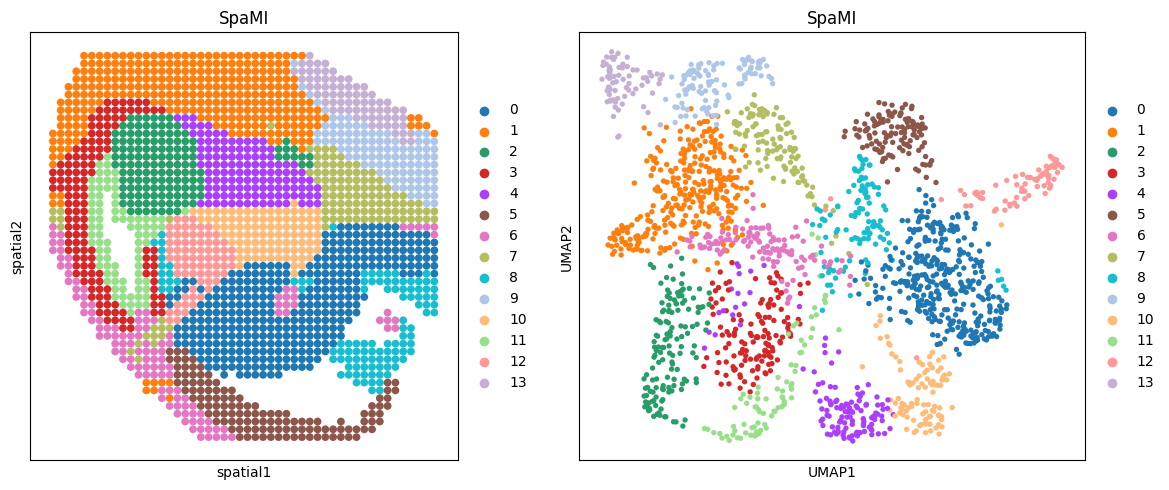

In [10]:
import matplotlib.pyplot as plt
fig, ax_list = plt.subplots(1, 2, figsize=(12, 5))

adata = AnnData(result)
adata.obsm['spatial'] = adata_omics1.obsm['spatial']

# sc.pp.pca(adata, n_comps=20)
sc.pp.neighbors(adata, n_neighbors=50, use_rep='X')
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=1)
sc.pl.umap(adata, color='leiden', ax=ax_list[1], title='SpaMI', s=60, show=False)
sc.pl.spatial(adata, color='leiden', spot_size=1, ax=ax_list[0], title='SpaMI', show=False)


plt.tight_layout(w_pad=0.5)
plt.show()